# Customers churn analysis

Clients started leaving Beta-Bank. Every month. A little, but noticeable. Bank marketers figured that calling current customers is cheaper than attracting new ones. **The project goal**: to predict whether the client will leave the bank in the near future or not.

**Data**: historical data on customer behavior and termination of agreements with the bank. It is necessary to build a model with a high level of F1-measure.

<h1>Table of content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#Models-testing" data-toc-modified-id="Models-testing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Models testing</a></span></li><li><span><a href="#Classes-balancing" data-toc-modified-id="Classes-balancing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Classes balancing</a></span></li><li><span><a href="#Checking-the-model-on-a-test-sample" data-toc-modified-id="Checking-the-model-on-a-test-sample-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Checking the model on a test sample</a></span></li></ul></div>

## Data preprocessing

**Loading the required libraries and open the data**

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings

# mute notifications
warnings.filterwarnings('ignore')

# import data
data = pd.read_csv('Churn.csv')
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Checking basic information about dataset

In [4]:
print(data.info())
print('')
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None

         RowNumber    CustomerId   CreditScore           Age       Tenure  \
count  1000

Based on the information received, the dataset contains 10,000 observations that display information about the bank's clients, as well as whether the client has left the bank. The dataset contains the following thirteen variables:

- RowNumber - the index of the row in the data;
- CustomerId - unique customer identifier;
- Surname - surname;
- CreditScore - credit rating;
- Geography - country of residence;
- Gender - gender;
- Age - age;
- Tenure - how many years a person has been a client of the bank;
- Balance - account balance;
- NumOfProducts - the number of bank products used by the client;
- HasCrCard - availability of a credit card;
- IsActiveMember - client activity;
- EstimatedSalary - estimated salary;
- Exited - the fact of the client leaving.

If we talk about the types of variables, then there are three types in the dataset:

- strings: variables 'Surname', 'Geography' and 'Gender';
- integers: variables 'RowNumber', 'CustomerId', 'CreditScore', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'IsActiveMember', 'Exited' (many of these variables are binary, reflecting the fact or his absence);
- real numbers: variables 'Tenure', 'Balance', 'EstimatedSalary'.

Let's check the data for gaps and duplicates:

In [13]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There were 909 missing values in the variable representing the number of years a person has been a customer of the bank. Let's look at the values of this variable to see if the gaps can be filled with the median / mean:

In [14]:
Tenure_max = data['Tenure'].max()
Tenure_min = data['Tenure'].min()
Tenure_mean = data['Tenure'].mean()
Tenure_median = data['Tenure'].median()
print('Maximum number of years:', Tenure_max)
print('Minimal number of years:', Tenure_min)
print('Average number of years:', Tenure_mean)
print('Median number of years:', Tenure_median)

Maximum number of years: 10.0
Minimal number of years: 0.0
Average number of years: 4.9979
Median number of years: 5.0


As can be seen, both the median and average values are very close to each other and are about 5 years. In this regard, I propose to fill in the gaps with a value of 5 (median):

In [15]:
data['Tenure'] = data['Tenure'].fillna(Tenure_median)
print(data['Tenure'].isna().sum())

0


Let's also check the data for duplicates:

In [16]:
data.duplicated().sum()

0

There are no dublicates in dataset.

**Preparing features for machine learning**

To begin with, I propose to simplify the dataset by removing unnecessary variables from it. Firstly, let's see the values of the 'RowNumber' variable:

In [17]:
data['RowNumber'].unique()

array([    1,     2,     3, ...,  9998,  9999, 10000])

As can be seen, this variable duplicates line numbers and does not carry any semantic meaning for subsequent models. It can be removed.

Also, given the main task - to predict whether a customer will leave the bank or not, two variables ('CustomerId' and 'Surname') will not make any difference, because with a high degree of probability they are not able to influence the customer's churn. Therefore, these variables can also be deleted. But just in case, let's first check these variables for duplicates:

In [18]:
print(data['CustomerId'].value_counts().sum())
print(data['Surname'].value_counts().sum())

10000
10000


There are no dublicates, so we can carry out manipulations to remove three variables:

In [19]:
data_new = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data_new.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Next, let's work with categorical variables: 'Geography' and 'Gender'. To transform variables into dummies, I will use the OHE method:

In [20]:
data_new = pd.get_dummies(data_new, drop_first=True)
data_new.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


**Dividing the data into three samples: training, validation and test**

In [21]:
# Separating the training sample from the available data
# (equal to 60% of all data)
data_train, data2 = train_test_split(data_new, test_size=0.4, random_state=12345) 
print(data_train.shape)
print(data2.shape)

(6000, 12)
(4000, 12)


In [22]:
# The remaining 40% of the sample will be divided into test 
# and validation samples (50% each, that is, 20% of the original data)
data_valid, data_test = train_test_split(data2, test_size=0.5, random_state=12345)
print(data_valid.shape)
print(data_test.shape)

(2000, 12)
(2000, 12)


Thus, there are three samples:

- Training (data_train) with 6000 observations (60%);
- Validation (data_valid) from 2000 observations (20%);
- Test (data_test) with 2000 observations (20%).

Now let's set variables with features and a target parameter (client leaving):

In [24]:
# Subset for train sample:
features_train = data_train.drop(['Exited'], axis=1)
target_train = data_train['Exited']

# Subset for validation sample:
features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited']

# Subset for test sample:
features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']

# Checking shapes of new subsamples:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 11)
(6000,)
(2000, 11)
(2000,)
(2000, 11)
(2000,)


**Features scaling**

Scaling is carried out for numerical features (not dummy), so they should be fixed in a separate variable:

In [25]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

# Train sample:
features_train[numeric] = scaler.transform(features_train[numeric])

# Validation sample:
features_valid[numeric] = scaler.transform(features_valid[numeric]) 

# Test sample:
features_test[numeric] = scaler.transform(features_test[numeric]) 

# Transformation results on the training sample:
features_train.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.082277,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.082277,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.737696,1.027098,0.830152,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.354288,-1.233163,0.830152,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.101690,1.140475,-0.891560,0,0,1.524268,1,0,0


Thus, the data was prepared for subsequent machine learning:

- The sample, number and types of variables were examined;
- A check for missing values was performed, the missing values in the 'Tenure' variable were filled with median value (= 5), and a duplicate check was also performed;
- Extra variables have been removed;
- Direct encoding (OHE) of the 'Geography' and 'Gender' variables was carried out, which made it possible to transform them into dummy variables;
- The sample was divided into three new ones: training, validation and test;
- Scaling of numerical features was carried out.

Now, the data is ready for subsequent machine learning manipulations.

## Models testing

Firstly, let's build three models: logistic regression, decision tree and random forest and compare their accuracy. To do this, let's write the accuracy_score function:

In [26]:
def models_accuracy_score(features_train, target_train, features_valid, target_valid):
    
    # Logistic regression:
    model_logit = LogisticRegression(random_state = 12345)
    model_logit.fit(features_train, target_train)
    logit_score = model_logit.score(features_valid, target_valid)
    
    # Decision tree:
    model_tree = DecisionTreeClassifier(random_state = 12345)
    model_tree.fit(features_train, target_train)
    tree_score = model_tree.score(features_valid, target_valid)
    
    # Random forest:
    model_forest = RandomForestClassifier(random_state=12345)
    model_forest.fit(features_train, target_train)
    forest_score = model_forest.score(features_valid, target_valid)
    
    print('Accuracy of Logistic regression:', logit_score, '\n' 
          'Accuracy of Decision tree:', tree_score, '\n'
          'Accuracy of Random Forest:', forest_score)

In [27]:
models_accuracy_score(features_train, target_train, features_valid, target_valid)

Accuracy of Logistic regression: 0.802 
Accuracy of Decision tree: 0.7935 
Accuracy of Random Forest: 0.8585


So, at the stage of studying the Accuracy value of the three models, the random forest model shows the best result: 0.8585. It should be noted that all three models have a fairly high level of proportion of correct answers (about 80% for each model), which can be explained by the class imbalance.

**Class balance testing**

Let's conduct a separate analysis of this phenomenon. Firstly, let's count the classes in the target variable:

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

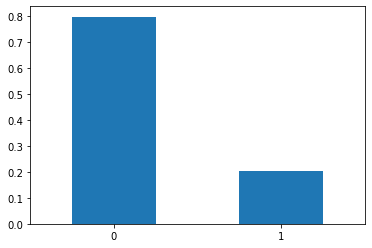

In [28]:
class_frequency = data_new['Exited'].value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind='bar', rot=0)

As can be seen, the ratio of customers who did not leave and who left is roughly 80% to 20%, reflecting a rather strong class imbalance that makes the models more likely to predict 0.

Let's also analyze the frequencies of the classes in the results of the predictions of all three models:

In [29]:
def models_class_frequency(features_train, target_train, features_valid, target_valid):
    
    # Logistic regression:
    model_logit = LogisticRegression(random_state = 12345)
    model_logit.fit(features_train, target_train)
    predicted_valid_logit = pd.Series(model_logit.predict(features_valid))
    class_frequency_logit = predicted_valid_logit.value_counts(normalize = True)
    
    # Decision tree:
    model_tree = DecisionTreeClassifier(random_state = 12345)
    model_tree.fit(features_train, target_train)
    predicted_valid_tree = pd.Series(model_tree.predict(features_valid))
    class_frequency_tree = predicted_valid_tree.value_counts(normalize = True)

    # Random forest:
    model_forest = RandomForestClassifier(random_state=12345)
    model_forest.fit(features_train, target_train)
    predicted_valid_forest = pd.Series(model_forest.predict(features_valid))
    class_frequency_forest = predicted_valid_forest.value_counts(normalize = True)
    
    print('Logistic regression response shares:', class_frequency_logit, '\n' 
          'Decision tree response shares:', class_frequency_tree, '\n'
          'Random forest response shares:', class_frequency_forest)

In [30]:
models_class_frequency(features_train, target_train, features_valid, target_valid)

Logistic regression response shares: 0    0.913
1    0.087
dtype: float64 
Decision tree response shares: 0    0.7955
1    0.2045
dtype: float64 
Random forest response shares: 0    0.8745
1    0.1255
dtype: float64


As can be seen, there is a strong imbalance in predictions. For example, logistic regression predicts a negative outcome in more than 90% of cases. The random forest, which previously showed high accuracy, also strongly tends to predict 0.

Let's compare the results obtained with the constant model:

In [31]:
target_pred_constant = pd.Series(np.zeros_like(target_valid))
print(accuracy_score(target_valid, target_pred_constant))

0.791


The constant model shows results that are close to what we obtained earlier when testing the three models. The problem is class imbalance.

To do better testing of the models, let's turn to the F1 metric:

In [32]:
def models_f1_score(features_train, target_train, features_valid, target_valid):
    
    # Logistica regression:
    model_logit = LogisticRegression(random_state = 12345)
    model_logit.fit(features_train, target_train)
    predicted_valid_logit = pd.Series(model_logit.predict(features_valid))
    logit_f1_score = f1_score(target_valid, predicted_valid_logit)
    
    # Devision tree:
    model_tree = DecisionTreeClassifier(random_state = 12345)
    model_tree.fit(features_train, target_train)
    predicted_valid_tree = pd.Series(model_tree.predict(features_valid))
    tree_f1_score = f1_score(target_valid, predicted_valid_tree)
    
    # Random forest:
    model_forest = RandomForestClassifier(random_state=12345, n_estimators = 80)
    model_forest.fit(features_train, target_train)
    predicted_valid_forest = pd.Series(model_forest.predict(features_valid))
    forest_f1_score = f1_score(target_valid, predicted_valid_forest)
    
    print('F1 of Logistic regression:', logit_f1_score, '\n' 
          'F1 of Decision Tree:', tree_f1_score, '\n'
          'F1 of Random forest:', forest_f1_score)

In [33]:
models_f1_score(features_train, target_train, features_valid, target_valid)

F1 of Logistic regression: 0.33108108108108103 
F1 of Decision Tree: 0.5006045949214026 
F1 of Random forest: 0.5787106446776611


Since F1 reflects the ratio of recall and accuracy, the higher it is, the more harmonious this ratio. As can be seen from the results presented, the most harmonious relationship is observed in the random forest model. Therefore, I further propose to continue to work on improving the quality of this model for the final model training.

**Choosing hyperparameters for the Random Forest:**

In [34]:
best_model = None
best_result = 0
for est in range(10, 25):
    for i in range(10, 20):
        model_forest = RandomForestClassifier(random_state=12345, 
                                              n_estimators= est, 
                                              max_depth = i) 
        model_forest.fit(features_train, target_train)
        predicted_valid_forest = model_forest.predict(features_valid)
        result = f1_score(target_valid, predicted_valid_forest)
        if result > best_result:
            best_model = model_forest
            best_result = result

print("max_est =", best_model.n_estimators, end='')
print('')
print("max_depth =", best_model.max_depth, end='')
print('')
print("F1 of the best model: {:.4f}".format(best_result))


max_est = 15
max_depth = 14
F1 of the best model: 0.5941


So, the best result of the F1 metric (0.59) for the Random Forest model was achieved with depth = 14 and number of trees = 15.

## Classes balancing

**Upsampling**

The first measure that should be taken to improve the quality of the model is to balance the classes, as their strong imbalance was previously identified. The first way to balance classes is to increase the number of the most important classes.

To do this, let's create the upsample function and apply it to the most successful model - a random forest:

In [44]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9588, 11)
(9588,)


Let's check the balance of classes on an enlarged sample:

In [47]:
# making target_upsampled as a table with 'Exited' values
target_upsampled_df = pd.DataFrame({'index':target_upsampled.index, 'Exited':target_upsampled.values})
target_upsampled_df.head(5)

,index,Exited
0,3637,1
1,3248,0
2,7516,0
3,7542,0
4,3490,1


0    0.501043
1    0.498957
Name: Exited, dtype: float64


<AxesSubplot:>

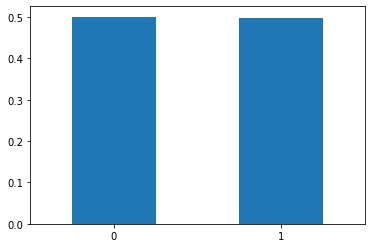

In [48]:
class_frequency = target_upsampled_df['Exited'].value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind='bar', rot=0)

As can be seen, with an increase in the presence of significant categories in the sample by 4 times, it was possible to achieve a balance in the prediction of classes. Let's see what happens when training a Random Forest on a larger sample: 

In [49]:
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_upsampled, target_upsampled) 
predicted_valid_upsampled = model_forest.predict(features_valid)
print("F1 on upsampled sample:", f1_score(target_valid, predicted_valid_upsampled))

F1 on upsampled sample: 0.6084656084656085


As can be seen, by increasing the sample, it was not possible to significantly increase the value of the prediction quality F1. But still it helped to reach the value = 0.6. 

**Downsampling**

Let's also try the second option for - downsampling, which allows to remove some of the objects of a larger class:

In [73]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]) 
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]) 
    features_downsampled = shuffle(features_downsampled, random_state=12345)
    target_downsampled = shuffle(target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2637, 11)
(2637,)


Let's check the balance of classes on a downsampled sample:

In [74]:
# making target_downsampled as a table with values 'Exited'
target_downsampled_df = pd.DataFrame({'index':target_downsampled.index, 'Exited':target_downsampled.values})
target_downsampled_df.head(5)

,index,Exited
0,2872,1
1,7748,1
2,1409,0
3,1657,1
4,3623,0


0    0.546454
1    0.453546
Name: Exited, dtype: float64


<AxesSubplot:>

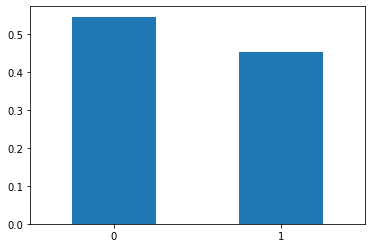

In [75]:
class_frequency = target_downsampled_df['Exited'].value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind='bar', rot=0)

So, downsampling has made it possible to somewhat improve the class imbalance problem. Let's check if this helps to get a higher value of the model prediction quality:

In [77]:
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_downsampled, target_downsampled) 
predicted_valid_downsampled = model_forest.predict(features_valid)
print("F1 on downsampled sample:", f1_score(target_valid, predicted_valid_downsampled))

F1 on downsampled sample: 0.5981688708036622


In [78]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators = 80)
model_forest.fit(features_train, target_train)
predicted_valid_forest = pd.Series(model_forest.predict(features_valid))
print("F1 on unbalanced sample:", f1_score(target_valid, predicted_valid_forest))

F1 on unbalanced sample: 0.5787106446776611


As a result, the downsampling only slightly affected the F1 parameter, so this measure should be abandoned.

**Hyperparameters of Random forest model for upsampled data**

Let's go back to the upsampled data and check which hyperparameter values give the best results:

In [80]:
best_model = None
best_result = 0
for est in range(10, 25):
    for i in range(10, 20):
        model_forest = RandomForestClassifier(random_state=12345, 
                                              n_estimators= est, 
                                              max_depth = i) 
        model_forest.fit(features_upsampled, target_upsampled)
        predicted_valid_upsampled = model_forest.predict(features_valid)
        result = f1_score(target_valid, predicted_valid_upsampled)
        if result > best_result:
            best_model = model_forest
            best_result = result

print("max_est =", best_model.n_estimators, end='')
print('')
print("max_depth =", best_model.max_depth, end='')
print('')
print("F1 of the best model on upsampled sample: {:.4f}".format(best_result))  


max_est = 20
max_depth = 14
F1 of the best model on upsampled sample: 0.6275


All in all, as a result of maipulations with data, the highest F1 value, which was achieved, is about 0.62. It was obtained using the model of the Random Forest on an enlarged sample with the following hyperparameters:

- n_estimators = 20
- max_depth = 14.

In [81]:
model_forest_final = RandomForestClassifier(random_state=12345, 
                                              n_estimators=20, 
                                              max_depth=14) 
model_forest_final.fit(features_upsampled, target_upsampled)
predicted_valid_upsampled_final = model_forest_final.predict(features_valid)
result = f1_score(target_valid, predicted_valid_upsampled_final)
print("F1 of final model:", result)        

F1 of final model: 0.6274509803921569


Additionally, the AUC-ROC can be measured and compared with the obtained F1 value:

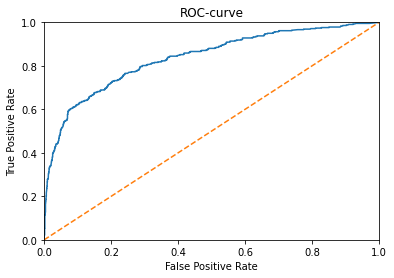

In [87]:
probabilities_valid = model_forest_final.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)

# ROC-curve of the random model
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()

In [83]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC of final model:", auc_roc)

AUC-ROC of final model: 0.8368850525347964


The quality metric AUC-ROC allows to compare the model with a random model. Using our model, we managed to reach a value of ≈ 0.83, which indicates a fairly good quality of the model.

In this way, thanks to the manipulations carried out, it was possible to:
- tackle class imbalance by increasing the sample size;
- find the hyperparameters at which the random forest model produced the highest value F1 = 0.62;
- analyze the AUC-ROC metric, which has confirmed a fairly decent quality of the model.

Next, the selected model on a test sample will be analyzed. 

## Checking the model on a test sample

In [84]:
final_prediction = model_forest_final.predict(features_test)
print("F1 of the test model:", f1_score(target_test, final_prediction))

F1 of the test model: 0.5749690210656753


In [85]:
final_probabilities = model_forest_final.predict_proba(features_test)
final_probabilities_one = probabilities_valid[:, 1]

final_auc_roc = roc_auc_score(target_test, final_probabilities_one)

print("AUC-ROC of the test model", auc_roc)

AUC-ROC of the test model 0.8368850525347964


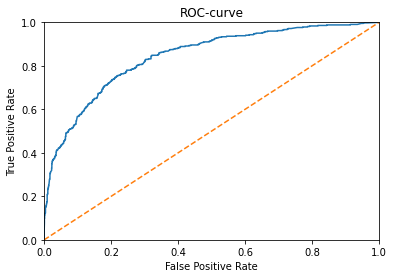

In [88]:
probabilities_test = model_forest_final.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()
plt.plot(fpr, tpr)

# ROC-curve of the random model
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()

To summarize, the work done allowed to build a model that showed decent values on the test sample:

- F1 is around 0.57. This means that the ratio of completeness and accuracy metrics is around 6:4;
- The AUC-ROC is 0.83. This measure shows how much the constructed model differs from the predictions of the random model. Since the obtained value is greater than 0.5, we can say that the constructed model predicts an order of magnitude better than a random one and can be used to predict the churn of bank customers.